# TAEHV Training

This notebook demonstrates how to distill a tiny video encoder / decoder.

## Config

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

import glob
import random
from collections import namedtuple
from functools import lru_cache
from pathlib import Path

import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm
import io
import base64

import cv2

th.backends.cudnn.benchmark = True

In [2]:
class Config:
    # Train the encoder?
    train_encoder = True
    # Train the decoder?
    train_decoder = True

    # Dataset folder to search for videos in
    dataset_path = "video_dataset"
    
    # Height / width of patches used for training
    hw = 64
    # Number of patches to show in visualizations
    n_demo = 5
    # Frames to train
    n_frames = 12
    
    # Device and dtype to use for reference model
    device = "cuda"
    ref_dtype = th.bfloat16

    # dtype to use for trained model
    dtype = th.float32

## Dataset

The dataset code will load videos from the dataset folder and crop out random patches.

In [3]:
def show(x):
    if not isinstance(x, th.Tensor) or x.ndim == 4:
        x = th.cat(tuple(x), -1)
    display(TF.to_pil_image(x))

def show_anim(x):
    assert isinstance(x, (list, tuple)), "show_anim requires sequence of frames"
    if isinstance(x[0], th.Tensor):
        if x[0].ndim == 4:
            x = [th.cat(tuple(x_t), -1) for x_t in x]
        x = [TF.to_pil_image(x_t) for x_t in x]
    video_buff = io.BytesIO()
    x[0].save(video_buff, append_images=x[1:], save_all=True, duration_ms=1000/30, loop=0, format="GIF")
    video_buff.seek(0)
    video_b64 = base64.b64encode(video_buff.getvalue()).decode('utf-8')
    display(HTML(f"<img src='data:image/gif;base64,{video_b64}'/>"))

def show_latents(x):
    show(F.interpolate(x[:, :3].add(0.5).mul_(0.3).clamp_(0, 1), scale_factor=8))

def load_frames_from_vid(vid, n_frames, min_frame_delta=1, max_frame_delta=5):
    if isinstance(vid, Path): vid = str(vid.resolve())
    frame_delta = random.randint(min_frame_delta, max_frame_delta)
    cap = cv2.VideoCapture(vid)
    cap_n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.set(cv2.CAP_PROP_POS_FRAMES, random.randrange(0, cap_n_frames))
    out = []
    for i in range(n_frames):
        for i in range(frame_delta):
            ret, frame = cap.read()
        if frame is None:
            # try again at start
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            ret, frame = cap.read()
        # BGR->RGB
        out.append(Image.fromarray(frame[:, :, ::-1]))
    return out

def random_resize_crop(ims, patch_hw):
    # pad as needed in case there are tiny images
    if min(ims[0].size) < patch_hw:
        px = patch_hw - ims[0].width
        py = patch_hw - ims[0].height
        ims = [TF.pad(
            im, (px // 2, px - px // 2, py // 2, py - py // 2), padding_mode="reflect"
        ) for im in ims]
    crop_hw = random.randint(patch_hw, max(patch_hw, min(ims[0].size)))
    crop_x = random.randrange(0, ims[0].width - crop_hw) if ims[0].width > crop_hw else 0
    crop_y = random.randrange(0, ims[0].height - crop_hw) if ims[0].height > crop_hw else 0
    patches = [im.crop((crop_x, crop_y, crop_x + crop_hw, crop_y + crop_hw)) for im in ims]
    return [patch.resize((patch_hw, patch_hw), Image.BICUBIC) for patch in patches]


class Dataset(th.utils.data.Dataset):
    def __init__(self, p, patch_hw, n_frames, video_extensions=["mp4"]):
        # no pathlib glob here, pathlib glob is bad with symlinks and hidden files
        self.vids = sum([glob.glob(p + f"/**/*.{ext}", recursive=True) for ext in video_extensions], [])
        self.patch_hw = patch_hw
        self.n_frames = n_frames

    def __len__(self):
        return len(self.vids)

    def __getitem__(self, i):
        ims = load_frames_from_vid(self.vids[i], self.n_frames)
        ims = random_resize_crop(ims, self.patch_hw)
        ims = [im.convert("RGB") for im in ims]
        ims = [TF.pil_to_tensor(im) for im in ims]
        return th.stack(ims, 0) # TCHW


d_train = Dataset(Config.dataset_path, Config.hw, Config.n_frames)
print(f"Got {len(d_train)} videos from {Config.dataset_path}")

Got 973 videos from video_dataset



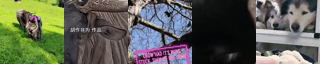

In [4]:
def demo_cpu_dataset(dataset):
    show_anim(th.stack([random.choice(dataset) for _ in range(Config.n_demo)], 0).unbind(1))

demo_cpu_dataset(d_train)

## Reference VAE

The reference VAE will be used to convert patches into latents.

Loading reference VAE...


/home/ubuntu/.local/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/ubuntu/.local/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
2025-06-15 00:49:13.204208: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-15 00:49:13.248869: I tensorfl

Loaded reference VAE...



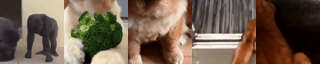

Latents 0.05757994204759598 0.6664450764656067


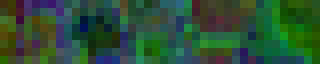

Decoded Images



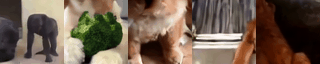

In [5]:
def get_ref_vae_wan():
    class RefVAE(nn.Module):
        def __init__(self):
            super().__init__()
            self.latent_channels = 16
            self.time_downscale = 4
            self.space_downscale = 8
            from diffusers import AutoencoderKLWan
            self.vae = AutoencoderKLWan.from_pretrained("Wan-AI/Wan2.1-T2V-1.3B-Diffusers", subfolder="vae", torch_dtype=Config.ref_dtype)
    
        @th.no_grad()
        def encode_video(self, x):
            assert x.ndim == 5 # NTCHW
            assert x.shape[2] % 3 == 0 # image channels
            x = x.transpose(1, 2)
            y = x.to(Config.ref_dtype).mul(2).sub_(1)
            y = self.vae.encode(y).latent_dist.sample()
            return y.transpose(1, 2).to(x.dtype)
        
        @th.no_grad()
        def decode_video(self, x):
            assert x.ndim == 5 # NTCHW
            assert x.shape[2] % self.latent_channels == 0
            x = x.transpose(1, 2)
            # B, C, T, H, W
            y = x.to(Config.ref_dtype)
            y = self.vae.decode(y).sample
            y = y.mul_(0.5).add_(0.5).clamp_(0, 1) # NCTHW
            return y.transpose(1, 2).to(x.dtype)
    
    return RefVAE()

print("Loading reference VAE...")
vae_ref = get_ref_vae_wan().to(Config.device, Config.ref_dtype).requires_grad_(False).eval()
print("Loaded reference VAE...")

def demo_vae_wrapper(dataset, vae):
    ims = (
        th.stack([random.choice(dataset) for _ in range(Config.n_demo)], 0)
    ).to(device=Config.device, dtype=Config.dtype).div_(255.0)
    show_anim(ims.unbind(1))

    latents = vae.encode_video(ims)
    print("Latents", latents.mean().item(), latents.std().item())
    show_latents(latents[:, 0])

    print("Decoded Images")
    show_anim(vae.decode_video(latents).unbind(1))


demo_vae_wrapper(d_train, vae_ref)

In [6]:
Sample = namedtuple("Sample", ("ims", "latent"))

def gpu_preprocess(ims):
    ims = ims.to(device=Config.device, dtype=Config.dtype).div_(255.0)
    latent = vae_ref.encode_video(ims)
    return Sample(ims.to(Config.dtype), latent.to(Config.dtype))

## TAEHV Model

Our TAEHV model will be trained to convert SDXL latents to and from RGB images.
We'll also load a pretrained TAEHV model for reference.

In [7]:
!wget -nc -q https://raw.githubusercontent.com/madebyollin/taehv/main/taehv.py
!wget -nc -q https://raw.githubusercontent.com/madebyollin/taehv/main/taew2_1.pth

In [8]:
from taehv import TAEHV

def count_params(label, m):
    n_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
    n_params_str = f"{n_params/1e6:.2f}M"
    return f"{label.ljust(16)}{n_params_str.rjust(8)} params"


model = TAEHV(None).to(device=Config.device, dtype=Config.dtype)
nn.init.constant_(model.decoder[-1].bias, 0.5)

print(count_params("model", model))

def weight_average(w_prev, w_new, n):
    alpha = min(0.95, n / 10)
    return alpha * w_prev + (1 - alpha) * w_new

avg_model = th.optim.swa_utils.AveragedModel(model, avg_fn=weight_average)

model             11.32M params


In [9]:
pretrained_model = TAEHV("taew2_1.pth")
pretrained_model = pretrained_model.to(device=Config.device, dtype=Config.dtype).eval().requires_grad_(False)

Latents (Reference Encoder)


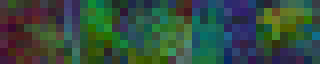

Latents (Pretrained Encoder)


  0%|          | 0/18 [00:00<?, ?it/s]

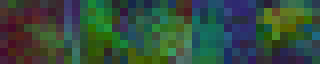

Latents (Our Encoder)


  0%|          | 0/18 [00:00<?, ?it/s]

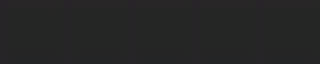

Decoded Images (Reference Decoder)



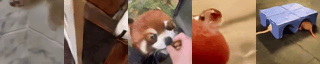

Decoded Images (Pretrained Decoder)


  0%|          | 0/23 [00:00<?, ?it/s]


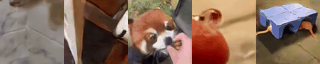

Decoded Images (Our Decoder)


  0%|          | 0/23 [00:00<?, ?it/s]


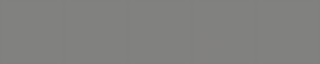

Original Images



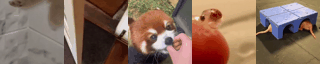

In [10]:
@th.no_grad()
def demo_taehv(xb, model, n=Config.n_demo):
    print("Latents (Reference Encoder)")
    show_latents(xb.latent[:n, 0])
    
    print("Latents (Pretrained Encoder)")
    show_latents(pretrained_model.encode_video(xb.ims[:n])[:, 0])
    
    print("Latents (Our Encoder)")
    show_latents(model.encode_video(xb.ims[:n])[:, 0])

    print("Decoded Images (Reference Decoder)")
    show_anim(vae_ref.decode_video(xb.latent[:n]).unbind(1))
    
    print("Decoded Images (Pretrained Decoder)")
    show_anim(pretrained_model.decode_video(xb.latent[:n]).clamp_(0, 1).unbind(1))

    print("Decoded Images (Our Decoder)")
    show_anim(model.decode_video(xb.latent[:n]).clamp_(0, 1).unbind(1))
    
    print("Original Images")
    show_anim(xb.ims[:n].unbind(1))


demo_taehv(gpu_preprocess(next(iter(th.utils.data.DataLoader(d_train, batch_size=Config.n_demo, shuffle=True)))), avg_model.module)

## Seraena

Seraena will be used to generate the training guidance for our decoder model.

In [11]:
!wget -nc -q https://raw.githubusercontent.com/madebyollin/seraena/main/seraena.py

In [12]:
from seraena import Seraena

# Number of frames to group into a chunk for the discriminator
Config.n_seraena_frames = 3
assert Config.n_frames % Config.n_seraena_frames == 0

# since it's not really possible to assign latents to specific frames,
# discriminate each triple of frames using the same (time-averaged) latents.
# we'll use the reconstruction loss to enforce latent <> frame consistency.
seraena = Seraena(3 * Config.n_seraena_frames, vae_ref.latent_channels).to(Config.device)
print(count_params("seraena", seraena))

seraena            7.49M params


/home/ubuntu/seraena.py:76: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = th.cuda.amp.GradScaler(enabled=use_amp)


## Training Loop

In [13]:
import datetime
import os
import time

from IPython.display import clear_output


class Visualizer:
    def __init__(self):
        self.losses_since_last_vis = []
        self.avg_losses = []
        self.steps = []
        self.step = 0
        self.t_last_vis = 0
        self.t_last_save = 0
        self.t_start = None
        folder, idx = (
            datetime.datetime.now().strftime("%Y_%m_%d")
            + "_taehv_example_training_logs",
            0,
        )
        while Path(f"{folder}_{idx}").exists():
            idx += 1
        self.folder = Path(f"{folder}_{idx}")
        self.folder.mkdir()

    @th.no_grad()
    def __call__(
        self,
        model,
        seraena,
        t,
        debug,
        losses,
        n_demo=Config.n_demo,
        visualize=False,
    ):
        self.losses_since_last_vis.append(sum(losses.values()).item())
        avg_loss = sum(self.losses_since_last_vis) / len(self.losses_since_last_vis)
        self.step += 1
        if self.t_start is None:
            self.t_start = t
        if visualize:
            clear_output(wait=True)
            disc_idx = th.randperm(len(debug["disc_in"]))[:n_demo]
            print("Seraena Input Images / Latents")
            show(debug["disc_in"][disc_idx, :3].clamp(0, 1))
            show_latents(debug["disc_in_ctx"][disc_idx, :3])
            print("Seraena Predictions")
            show(
                F.interpolate(
                    debug["disc_pred"][disc_idx, :3].mean(1, keepdim=True), debug["xb"].ims.shape[-2:]
                ).clamp(0, 1)
            )
            print("Seraena Targets")
            show(
                F.interpolate(
                    debug["disc_targets"][disc_idx, :3].mean(1, keepdim=True), debug["xb"].ims.shape[-2:]
                ).clamp(0, 1)
            )
            print(f"Seraena Loss: {debug['disc_loss']:.5f}")
            
            demo_taehv(debug["xb"], model)
            if Config.train_decoder:
                print("Total Decoder Corrections (negative grad)")
                show((debug["decoder_grad"])[:n_demo, 0].neg().add(0.5).clamp(0, 1))

            self.steps.append(self.step)
            self.avg_losses.append(avg_loss)
            self.losses_since_last_vis = []
            plt.title("Losses")
            plt.plot(
                self.steps,
                self.avg_losses,
                label=f"{self.folder} {self.avg_losses[-1]:.5f}",
            )
            plt.gcf().set_size_inches(16, 4)
            plt.ylim(0, 1.5 * self.avg_losses[-1])
            plt.legend()
            if t > self.t_last_save + 120:
                th.save(model.state_dict(), self.folder / "model.pth")
                th.save(seraena.state_dict(), trainer.visualizer.folder / "seraena.pth")
                th.save((self.steps, self.avg_losses), self.folder / "stats.pth")
                plt.gcf().savefig(self.folder / "stats.jpg")
                self.t_last_save = t
            plt.show()
            self.t_last_vis = t
        print(
            f"\r{self.step: 5d} Steps; {int(t - self.t_start): 3d} Seconds; "
            f"{60 * self.step / (t - self.t_start + 1):.1f} Steps / Min; "
            f"{len(debug['xb'].ims) * 60 * self.step / (t - self.t_start + 1):.1f} Images / Min; "
            f"Loss {avg_loss:.5f}",
            end="",
        )


class Trainer:
    def __init__(self, dataset, model, avg_model, seraena, batch_size=16):
        self.model = model
        self.avg_model = avg_model
        self.last_avg_time = time.time()
        self.opt = th.optim.AdamW(model.parameters(), 3e-4, betas=(0.9, 0.95))
        num_workers = min(
            12,
            len(os.sched_getaffinity(0))
            if hasattr(os, "sched_getaffinity")
            else os.cpu_count(),
        )
        self.dataloader = th.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
            num_workers=num_workers,
        )
        self.scaler = th.cuda.amp.GradScaler()
        self.dl_iter = iter(self.dataloader)
        self.seraena = seraena
        self.visualizer = Visualizer()
        self.n_steps = 0

    def avg_model_step(self, t):
        if t > self.last_avg_time + 2:
            self.avg_model.update_parameters(self.model)
            self.last_avg_time = t

    def get_batch(self):
        try:
            batch = next(self.dl_iter)
        except StopIteration:
            self.dl_iter = iter(self.dataloader)
            batch = next(self.dl_iter)
        return gpu_preprocess(batch)

    def train(self, n_seconds):
        self.model.train()
        start_time = time.time()
        while time.time() < start_time + n_seconds:
            self.train_step(time.time())

    def pad_and_group(self, x):
        assert x.shape[1] == Config.n_frames - self.model.frames_to_trim, f"{x.shape}??"
        assert x.shape[1] >= self.model.frames_to_trim, f"{x.shape}??"
        x = th.cat([x, x[:, :self.model.frames_to_trim]], 1)
        n, t, c, h, w = x.shape
        x = x.reshape(n * t//Config.n_seraena_frames, Config.n_seraena_frames*c, h, w)
        return x

    def ungroup_and_unpad(self, x):
        assert x.shape[1] == Config.n_seraena_frames*3, f"{x.shape}??"
        _, _, h, w = x.shape
        x = x.reshape(-1, Config.n_frames, 3, h, w)
        x = x[:, :-self.model.frames_to_trim]
        return x

    def train_step(self, t):
        xb = self.get_batch()
        
        debug = {"xb": xb}
        losses = {}

        if Config.train_encoder:
            with th.amp.autocast("cuda"):
                encoded = self.model.encode_video(xb.ims, parallel=True, show_progress_bar=False)
                losses["encoder"] = F.mse_loss(encoded, xb.latent)
                debug["encoded"] = encoded.detach()

        if Config.train_decoder:
            xb_ims_target = xb.ims[:, :-self.model.frames_to_trim]
            decoder_grad = th.zeros_like(xb_ims_target).requires_grad_(True)
            with th.amp.autocast("cuda"):
                decoded = self.model.decode_video(xb.latent, parallel=True, show_progress_bar=False) + decoder_grad
            target, seraena_debug = self.seraena.step_and_make_correction_targets(
                self.pad_and_group(xb_ims_target),
                self.pad_and_group(decoded),
                xb.latent.mean(1, keepdim=True).repeat_interleave(Config.n_frames//Config.n_seraena_frames, dim=1).flatten(0, 1), # time-average
            )
            target = self.ungroup_and_unpad(target).reshape(decoded.shape)
            debug.update(seraena_debug)
            debug["target"] = target
            with th.amp.autocast("cuda"):
                losses["reconstruction"] = F.mse_loss(decoded, xb_ims_target)
                losses["decoder"] = F.mse_loss(decoded, target)
                debug["decoded"] = decoded.detach()

        self.opt.zero_grad()
        self.scaler.scale(sum(losses.values())).backward()
        self.scaler.step(self.opt)
        self.scaler.update()
        self.avg_model_step(t)

        debug["decoder_grad"] = decoder_grad.grad.detach()
        self.visualizer(
            self.avg_model.module,
            self.seraena,
            t,
            debug,
            losses,
            visualize=(t > self.visualizer.t_last_vis + 30),
        )
        self.n_steps += 1


trainer = Trainer(d_train, model, avg_model, seraena)

/tmp/ipykernel_4105031/70787088.py:116: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = th.cuda.amp.GradScaler()


Seraena Input Images / Latents


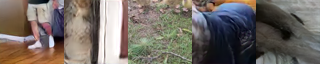

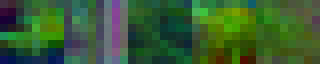

Seraena Predictions


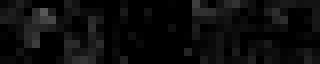

Seraena Targets


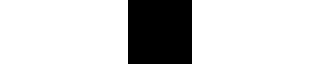

Seraena Loss: 0.73832
Latents (Reference Encoder)


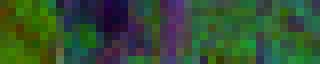

Latents (Pretrained Encoder)


  0%|          | 0/18 [00:00<?, ?it/s]

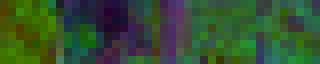

Latents (Our Encoder)


  0%|          | 0/18 [00:00<?, ?it/s]

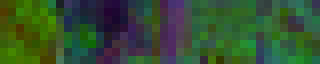

Decoded Images (Reference Decoder)



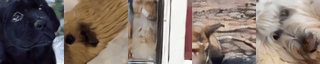

Decoded Images (Pretrained Decoder)


  0%|          | 0/23 [00:00<?, ?it/s]


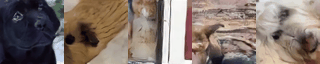

Decoded Images (Our Decoder)


  0%|          | 0/23 [00:00<?, ?it/s]


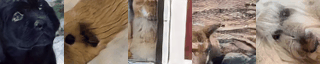

Original Images



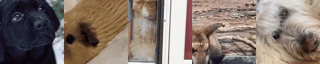

Total Decoder Corrections (negative grad)


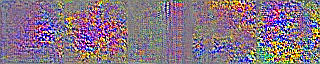

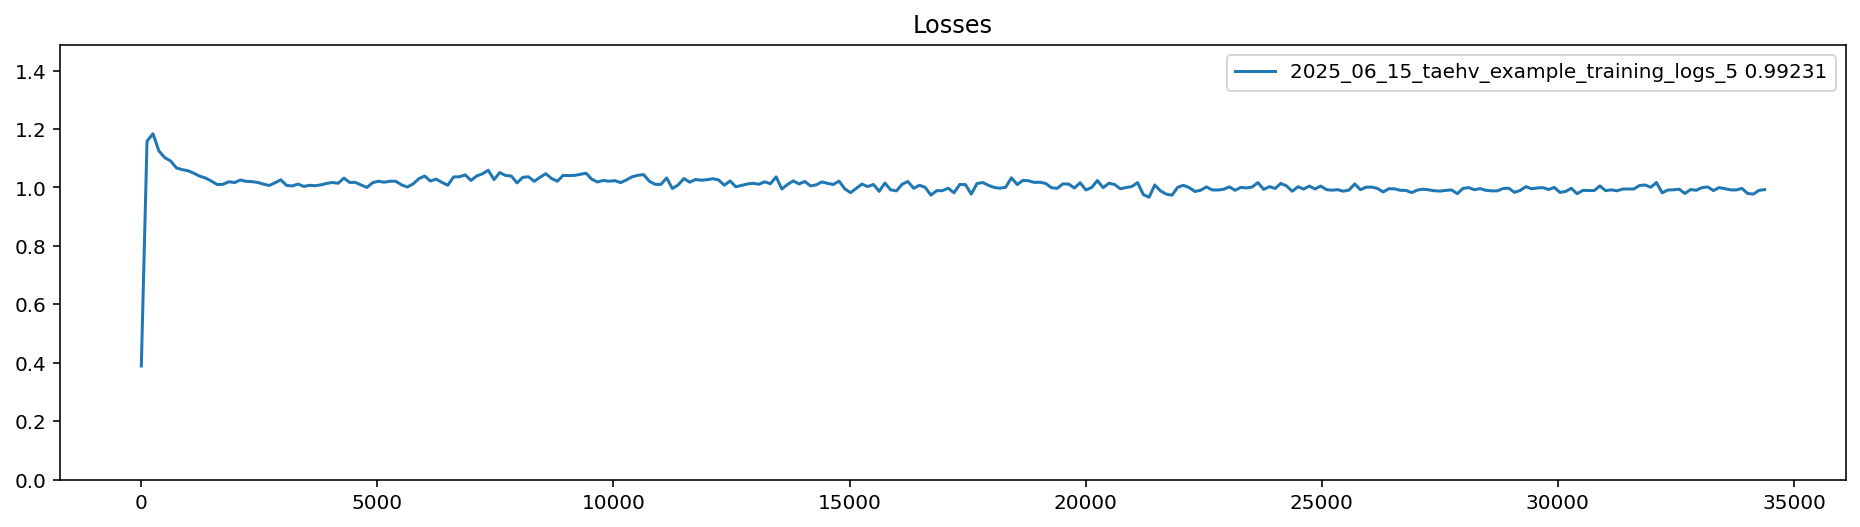

 34500 Steps;  8560 Seconds; 241.8 Steps / Min; 3868.4 Images / Min; Loss 1.00941

In [ ]:
trainer.train(n_seconds=24 * 60 * 60)